<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/NER/lstm/lstm_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54
* https://github.com/snehalnair/Named-Entity-Recognition


In [1]:
# Get the raw dataset

!curl -s -LO https://github.com/MahmooudTaha/NLP-2019/raw/master/ner_dataset.csv.zip
!unzip -o ner_dataset.csv.zip
!rm -f ner_dataset.csv.zip


import pandas as pd
from itertools import chain


def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    if token_or_tag == "token":
        vocab = list(set(data["Word"].to_list()))
    else:
        vocab = list(set(data["Tag"].to_list()))
    idx2tok = {idx: tok for idx, tok in enumerate(vocab)}
    tok2idx = {tok: idx for idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


data = pd.read_csv("/content/ner_dataset.csv", encoding="Windows-1252")
token2idx, idx2token = get_dict_map(data, "token")
tag2idx, idx2tag = get_dict_map(data, "tag")

data["Word_idx"] = data["Word"].map(token2idx)
data["Tag_idx"] = data["Tag"].map(tag2idx)

# Fill na
data_fillna = data.fillna(method="ffill", axis=0)

# Groupby and collect columns
data_group = data_fillna.groupby(["Sentence #"], as_index=False)["Word", "POS", "Tag", "Word_idx", "Tag_idx"].agg(lambda x: list(x))

# Visualise data
data_group.head()

Archive:  ner_dataset.csv.zip
  inflating: ner_dataset.csv         


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[29453, 24431, 972, 19273, 19658, 25560, 16911...","[3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5, 3, 3, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[2928, 25956, 18753, 23841, 33605, 10079, 1050...","[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[11750, 25537, 22242, 28605, 4287, 33319, 1730...","[3, 3, 13, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 15..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[26972, 23959, 15738, 23407, 7888, 27521, 1347...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[5753, 34147, 11510, 2580, 2140, 24732, 25928,...","[5, 3, 3, 10, 2, 3, 13, 3, 5, 3, 0, 3, 0, 3, 3..."


In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


def get_pad_train_test_val(data_group, data):

    # Get max token and tag length
    n_token = len(list(set(data["Word"].to_list())))
    n_tag = len(list(set(data["Tag"].to_list())))

    # Pad tokens (X var)    
    tokens = data_group["Word_idx"].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype="int32", padding="post", value= n_token - 1)

    # Pad Tags (y var) and convert it into one hot encoding
    tags = data_group["Tag_idx"].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype="int32", padding="post", value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    # Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size=0.25,train_size=0.75, random_state=2020)

    print(
        "train_tokens length:", len(train_tokens),
        "\ntrain_tokens length:", len(train_tokens),
        "\ntest_tokens length:", len(test_tokens),
        "\ntest_tags:", len(test_tags),
        "\nval_tokens:", len(val_tokens),
        "\nval_tags:", len(val_tags),
    )
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [3]:
from numpy.random import seed
from numpy import array
from tensorflow.random import set_seed
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# It's always best to set seed for reproducibility.
seed(1)
set_seed(2)


class LSTMModel:
  def __init__(self, input_dim, output_dim, input_length, n_tags, batch_size=1000, verbose=1, epochs=1, validation_split=0.2):
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_length = input_length
    self.n_tags = n_tags
    self.batch_size = batch_size
    self.verbose = verbose
    self.epochs = epochs
    self.validation_split = validation_split

  def build_model(self):
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=self.input_dim, output_dim=self.output_dim, input_length=self.input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=self.output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode="concat"))

    # Add LSTM
    model.add(LSTM(units=self.output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(self.n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    
    return model

  def train(self, X, y, loss_chart=True):
    loss = []
    model = self.build_model()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=self.batch_size, verbose=self.verbose, epochs=self.epochs, validation_split=self.validation_split)
        loss.append(hist.history["loss"][0])
    if loss_chart:
      results = pd.DataFrame()
      results["with_add_lstm"] = loss
      plt.plot(results['with_add_lstm'])
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
    return loss

input_dim:  35179 
output_dim:  64 
input_length:  104 
n_tags:  17
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
26/26 [==============================] - 30s 1s/step - loss: 0.0975 - accuracy: 0.9749 - val_loss: 0.1058 - val_accuracy: 0.9748


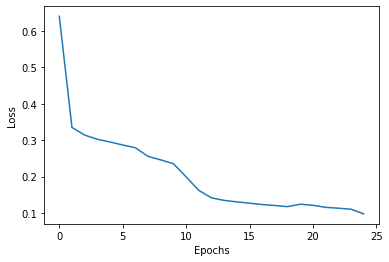

In [4]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group["Word_idx"].tolist()])
n_tags = len(tag2idx)
print("input_dim: ", input_dim, "\noutput_dim: ", output_dim, "\ninput_length: ", input_length, "\nn_tags: ", n_tags)

model = LSTMModel(input_dim, output_dim, input_length, n_tags, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
loss = model.train(train_tokens, array(train_tags), loss_chart=True)
# plot_model(model)
